In [32]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

In [33]:
# load all dfs
enrichr_df = pd.read_csv("enr_data/Enrichr_df.csv", index_col=0) # sorted by Term alphabetically
offline_df = pd.read_csv("enr_data/offline_df.csv", index_col=0) # sorted by Term alphabetically
string_df = pd.read_csv("enr_data/string_df.csv", index_col=0) # already sorted by fdr & by raw p-value
gsea_df = pd.read_csv("enr_data/gsea_df.csv", index_col=0) # sorted by absoulte NES
preranked_df = pd.read_csv("enr_data/preranked_df.csv", index_col=0) # sorted by absoulte NES

In [34]:
# sorting
enrichr_df.sort_values(by=['Adjusted P-value'], inplace=True, ascending=True)
offline_df.sort_values(by=['Adjusted P-value'], inplace=True, ascending=True)
enrichr_df.reset_index(drop=True, inplace=True)
offline_df.reset_index(drop=True, inplace=True)

In [35]:
# make index ranks
enrichr_df.index = enrichr_df.index + 1
offline_df.index = offline_df.index + 1
string_df.index = string_df.index + 1
gsea_df.index = gsea_df.index + 1
preranked_df.index = preranked_df.index + 1

In [36]:
enrichr_old_df = pd.read_csv("enr_data/Enrichr_df_old.csv", index_col=0)
enrichr_old_df.sort_values(by=['Adjusted P-value'], inplace=True, ascending=True)
enrichr_old_df.reset_index(drop=True, inplace=True)
enrichr_old_df.index = enrichr_old_df.index + 1
print((enrichr_df == enrichr_old_df).all())
print(enrichr_df.shape)


Gene_set             True
Term                 True
Overlap              True
P-value              True
Adjusted P-value     True
Odds Ratio           True
Combined Score       True
Genes               False
Proteins            False
dtype: bool
(224, 9)


In [37]:
print(enrichr_df.iloc[:10, 1:5].drop(columns=["Overlap", "P-value", "Adjusted P-value"]))
# a lot of duplicate values
# print(string_df["description"])

                                                 Term
1        Response to elevated platelet cytosolic Ca2+
2                              Platelet degranulation
3      Platelet activation, signaling and aggregation
4          Intrinsic Pathway of Fibrin Clot Formation
5          Post-translational protein phosphorylation
6   Regulation of Insulin-like Growth Factor (IGF)...
7         Formation of Fibrin Clot (Clotting Cascade)
8                       Retinoid cycle disease events
9                                  Alanine metabolism
10                    Diseases of the neuronal system


In [7]:
# functions
def jaccard_similarity(A, B):
    nominator = A.intersection(B)
    denominator = A.union(B)
    similarity = len(nominator)/len(denominator)
    return similarity

def mean_rank_difference(rank_dict_a, rank_dict_b):
    total_diff = 0
    rank_diff_list=[]

    for element, rank_b in rank_dict_b.items():
        if element in rank_dict_a:
            rank_a = rank_dict_a[element]
            rank_diff = abs(rank_a - rank_b)
            total_diff += rank_diff
            rank_diff_list.append(rank_diff)

    mean_rank_diff = total_diff / len(rank_dict_b)
    return mean_rank_diff, rank_diff_list

## check if enrichr and offline are the same

In [8]:
enrichr_df.compare(offline_df, align_axis=1, keep_shape=True)
all(enrichr_df == offline_df)

True

compare GO enrichment methods

In [9]:
print("number of")
print("enriched terms GSEApy", enrichr_df.shape[0], "enriched terms STRING", string_df.shape[0])

number of
enriched terms GSEApy 224 enriched terms STRING 5


In [10]:
# Can all of the string enriched terms be found in GSEApy results?
for term in string_df["description"].tolist():
    if term not in enrichr_df["Term"].tolist():
        print(term)
    else:
        print("found")

found
found
found
found
found


In [11]:
for col in enrichr_df.columns: # on column to find out if already sorted
    print(col, enrichr_df[col].is_monotonic_increasing)

Gene_set True
Term False
Overlap False
P-value False
Adjusted P-value True
Odds Ratio False
Combined Score False
Genes False
Proteins False


In [12]:
overlap_df = enrichr_df.loc[enrichr_df["Term"].isin(string_df["description"].tolist())]
print(overlap_df)

                Gene_set                                               Term  \
2   ReactomePathways.gmt                             Platelet degranulation   
4   ReactomePathways.gmt         Intrinsic Pathway of Fibrin Clot Formation   
5   ReactomePathways.gmt         Post-translational protein phosphorylation   
6   ReactomePathways.gmt  Regulation of Insulin-like Growth Factor (IGF)...   
13  ReactomePathways.gmt                                         Hemostasis   

   Overlap       P-value  Adjusted P-value  Odds Ratio  Combined Score  \
2     9/82  2.466298e-07          0.000034   11.758513      178.910215   
4     4/15  1.838297e-05          0.000877   27.238770      297.013883   
5     6/51  1.958012e-05          0.000877   12.213309      132.404435   
6     6/56  3.379333e-05          0.001262   11.121316      114.496698   
13  11/288  3.079131e-04          0.005306    4.068858       32.899538   

                                                Genes  \
2   CLEC3B;KNG1;A1BG;IT

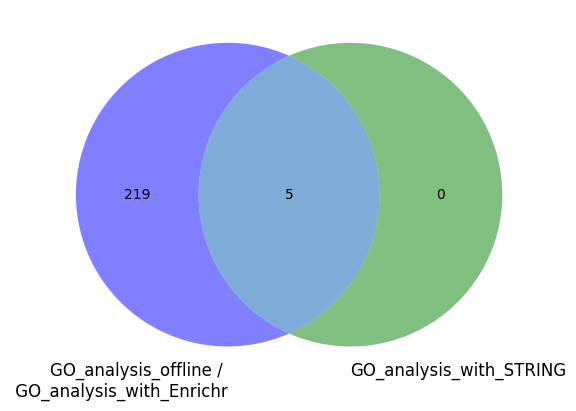

In [13]:
# venn diagram
#Import libraries
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted, venn3_unweighted
from matplotlib import pyplot as plt
# venn2(subsets = (224, 0, 5), set_labels = ('Group A', 'Group B'), set_colors=('skyblue', 'red'), alpha = 0.7)
venn2_unweighted(subsets = (219, 0, 5), set_labels = ('GO_analysis_offline / \n GO_analysis_with_Enrichr', 'GO_analysis_with_STRING'), set_colors=("b","g"), alpha = 0.5);
plt.savefig("VENN_GO.pdf", dpi=300)
# venn3_unweighted(subsets = (0, 0, 219, 0, 0, 0, 5), set_labels = ('GO_analysis_offline', 'GO_analysis_with_Enrichr', 'GO_analysis_with_STRING'), alpha = 0.5);
# plt.savefig("VENN_GO3.pdf", dpi=300)

In [14]:
# jaccard index
enrichr_terms = enrichr_df["Term"]
string_terms = string_df["description"]

enrichr_terms_s = set(enrichr_df["Term"])
string_terms_s = set(string_df["description"])
print("jaccard index", jaccard_similarity(enrichr_terms_s, string_terms_s))

enrichr_top_ten = set(enrichr_df.loc[:10, "Term"])
print("jaccard top ten", jaccard_similarity(enrichr_top_ten, string_terms))

enrichr_top_ten = set(enrichr_df.loc[:5, "Term"])
print("jaccard top five", jaccard_similarity(enrichr_top_ten, string_terms))

jaccard index 0.022321428571428572
jaccard top ten 0.36363636363636365
jaccard top five 0.42857142857142855


In [15]:
string_dict = dict(zip(string_df["description"], string_df.index))
overlap_dict = dict(zip(overlap_df["Term"], overlap_df.index))
# print(string_dict)
# print(overlap_dict)
print("mean rank difference", mean_rank_difference(string_dict, overlap_dict)[0])

mean rank difference 3.4


In [16]:
# pearson correlation of ranks
print(x := list(string_dict.values()))
print(y := overlap_df.index.tolist())
print("numpy", np.corrcoef(x,y))
print("scipy", scipy.stats.pearsonr(x, y))
print("test", scipy.stats.pearsonr(np.array([1,2, 3, 4, 5]), np.array([1, 5, 4, 6, 13])))

# should this be on the values not on the ranks?
a = np.array(overlap_df["Adjusted P-value"])
b = np.array(string_df["p_value"])
print("spearman", overlap_df["Adjusted P-value"].corr(string_df["p_value"], method="spearman"))
xy = np.array([np.array(overlap_df["Adjusted P-value"]),np.array(string_df["p_value"])], dtype=object)
print(scipy.stats.spearmanr(a,b, axis=1))
print(scipy.stats.spearmanr(xy, axis=1))

[1, 2, 3, 4, 5]
[2, 4, 5, 6, 13]
numpy [[1.         0.90711474]
 [0.90711474 1.        ]]
scipy PearsonRResult(statistic=0.9071147352221454, pvalue=0.03350493454730273)
test PearsonRResult(statistic=0.8905881248488705, pvalue=0.0427239621501428)
spearman 0.8660254037844387
SignificanceResult(statistic=0.9746794344808963, pvalue=0.004818230468198566)
SignificanceResult(statistic=0.9746794344808963, pvalue=0.004818230468198566)


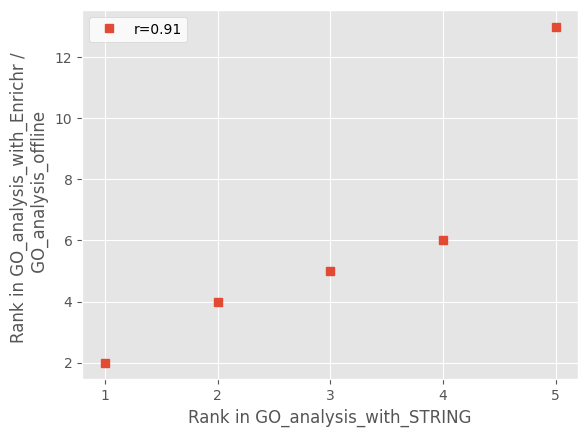

In [17]:
# plot
plt.style.use('ggplot')
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
# line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
line = f'r={r:.2f}'
# print(line)

fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='s', label=line)
# ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('Rank in GO_analysis_with_STRING')
ax.set_ylabel('Rank in GO_analysis_with_Enrichr / \n GO_analysis_offline')
ax.legend(facecolor='white')
ax.set_xticks(range(int(min(x)), int(max(x)) + 1))
plt.savefig("pearson_GO.pdf", dpi=300)
plt.show()

## GSEA Methods

In [19]:
# sorted by absolute NES value
copied_df = gsea_df.copy(deep=True)
gsea_df["abs_NES"]=gsea_df["NES"].abs()
print(gsea_df["abs_NES"].is_monotonic_decreasing)
gsea_df.drop(columns="abs_NES")
print((copied_df == gsea_df).all())
#---
copied_df = preranked_df.copy(deep=True)
preranked_df["abs_NES"]=preranked_df["NES"].abs()
print(preranked_df["abs_NES"].is_monotonic_decreasing)
preranked_df.drop(columns="abs_NES")
print((copied_df == preranked_df).all())

True
Name             True
Term             True
ES               True
NES              True
NOM p-val        True
FDR q-val        True
FWER p-val       True
Tag %            True
Gene %           True
Lead_genes       True
Lead_proteins    True
abs_NES          True
dtype: bool
True


ValueError: Can only compare identically-labeled DataFrame objects

In [20]:
# get top enriched terms
print(gsea_df.iloc[:10,1:2])
# print(preranked_df.iloc[:10,1:2])

                                    Term
1                             Metabolism
2                                Disease
3                 Metabolism of proteins
4   Metabolism of vitamins and cofactors
5           Transport of small molecules
6                          Immune System
7                   Innate Immune System
8            Metabolism of carbohydrates
9                Amyloid fiber formation
10         Cellular responses to stimuli


In [21]:
# are the 224 terms similar?
print(gsea_df.shape)
print(preranked_df.shape)
gsea_terms_s = set(gsea_df["Term"])
preranked_terms_s = set(preranked_df["Term"])
print("similar terms:", len(gsea_terms_s.intersection(preranked_terms_s)))
print("A - B:", len(gsea_terms_s.difference(preranked_terms_s)))

(224, 12)
(224, 12)
similar terms: 224
A - B: 0


In [22]:
# similar terms in top ten
gsea_top_ten = set(gsea_df.loc[:10, "Term"])
preranked_top_ten = set(preranked_df.loc[:10, "Term"])
print("similar terms in top 10: ", len(gsea_top_ten.intersection(preranked_top_ten)))
print("A - B:", len(gsea_top_ten.difference(preranked_top_ten)))

similar terms in top 10:  1
A - B: 9


In [23]:
# jaccard index
print("jaccard index", jaccard_similarity(gsea_terms_s, preranked_terms_s))

gsea_top_ten = set(gsea_df.loc[:10, "Term"])
preranked_top_ten = set(preranked_df.loc[:10, "Term"])
print("jaccard top ten", jaccard_similarity(gsea_top_ten, preranked_top_ten))

gsea_top_50 = set(gsea_df.loc[:50, "Term"])
preranked_top_50 = set(preranked_df.loc[:50, "Term"])
print("jaccard top 50", jaccard_similarity(gsea_top_50, preranked_top_50))

gsea_top_100 = set(gsea_df.loc[:100, "Term"])
preranked_top_100 = set(preranked_df.loc[:100, "Term"])
print("jaccard top 100", jaccard_similarity(gsea_top_100, preranked_top_100))

jaccard index 1.0
jaccard top ten 0.05263157894736842
jaccard top 50 0.5625
jaccard top 100 0.6949152542372882


In [24]:
# MRD
gsea_dict = dict(zip(gsea_df["Term"], gsea_df.index))
preranked_dict = dict(zip(preranked_df["Term"], preranked_df.index))
#print(preranked_dict)
# print(gsea_dict)
print("mean rank difference", mean_rank_difference(gsea_dict, preranked_dict)[0])


mean rank difference 22.785714285714285


22.785714285714285
14.0


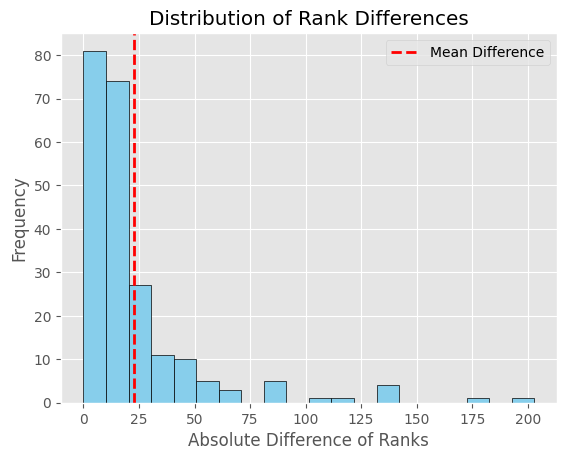

In [25]:
mean_difference, differences = mean_rank_difference(gsea_dict, preranked_dict)
print("mean difference", sum(differences)/len(differences))
print("median", np.median(np.array(differences)))
plt.hist(differences, bins=20, color='skyblue', edgecolor='black')
plt.axvline(mean_difference, color='red', linestyle='dashed', linewidth=2, label='Mean Difference')
plt.xlabel('Absolute Difference of Ranks')
plt.ylabel('Frequency')
plt.title('Distribution of Rank Differences')
plt.legend()
plt.show()

In [ ]:
# Calculate the frequency of each absolute difference value
unique_diff, counts = np.unique(differences, return_counts=True)

# Create a bar plot to show the rank differences
plt.bar(unique_diff, counts, color='skyblue', edgecolor='black')
plt.axhline(np.mean(counts), color='red', linestyle='dashed', linewidth=2, label='Mean Frequency')
plt.xlabel('Absolute Difference of Ranks')
plt.ylabel('Frequency')
plt.title('Distribution of Rank Differences')
plt.legend()
plt.show()

In [26]:
# pearson correlation of ranks
x = gsea_df.index.tolist() # use gsea as "truth"
# get ranks for values in gsea_df from preranked_df
df_2 = gsea_df
df_1 = preranked_df

# Add a temporary column to preserve the original index order
df_1['temp_index'] = df_1.index
df_2['temp_index'] = df_2.index
# Merge the two DataFrames based on the "Term" column
merged = df_2.merge(df_1, on='Term', how='left', indicator=True)
# Sort the result based on the index from df_1 to get the corresponding index in df_2
result = merged.sort_values(by='temp_index_x')[['Term', 'temp_index_y']]
# Rename the column to "df_2_index" for clarity
result.rename(columns={'temp_index_y': 'df_2_index'}, inplace=True)
# Drop the temporary columns
df_1.drop(columns='temp_index', inplace=True)
df_2.drop(columns='temp_index', inplace=True)
print(result.iloc[:10])
print(preranked_df.iloc[23:24])

                                   Term  df_2_index
0                            Metabolism          24
1                               Disease          36
2                Metabolism of proteins          10
3  Metabolism of vitamins and cofactors          15
4          Transport of small molecules         183
5                         Immune System          73
6                  Innate Immune System          72
7           Metabolism of carbohydrates          91
8               Amyloid fiber formation          32
9         Cellular responses to stimuli         150
       Name        Term        ES       NES  NOM p-val  FDR q-val  FWER p-val  \
24  prerank  Metabolism  0.675924  1.219237     0.1002        1.0         1.0   

   Tag %  Gene %                           Lead_genes  \
24  7/18  28.07%  TTR;RBP4;PRELP;GATM;DDAH1;APOA1;LUM   

                                        Lead_proteins   abs_NES  
24  A0A087WT59;A0A087WV45;A6XGL1;A6XMH1;E9KL36;P02...  1.219237  


In [31]:
# pearson correlation of ranks
x = gsea_df.index.tolist() # use gsea as "truth"

def sort_dict_by_order(reference_dict, dict_to_sort):
    sorted_items = sorted(dict_to_sort.items(), key=lambda x: list(reference_dict.keys()).index(x[0]))
    sorted_dict = {k: v for k, v in sorted_items}
    return sorted_dict

preranked_dict_sorted = sort_dict_by_order(gsea_dict, preranked_dict)
y = list(preranked_dict_sorted.values())

print("numpy", np.corrcoef(x,y))
print("scipy", scipy.stats.pearsonr(x, y))

# should this be on the values not on the ranks?
a = np.array(gsea_df["NES"])
b = np.array(preranked_df["NES"])
gsea_df["abs_NES"] = gsea_df["NES"].abs()
preranked_df["abs_NES"] = preranked_df["abs_NES"].abs()
print("spearman", gsea_df["abs_NES"].corr(preranked_df["abs_NES"], method="spearman"))
print(scipy.stats.spearmanr(np.array(gsea_df["abs_NES"]),np.array(preranked_df["abs_NES"]), axis=1))
print(scipy.stats.spearmanr(a,b, axis=1))

numpy [[1.         0.83294896]
 [0.83294896 1.        ]]
scipy PearsonRResult(statistic=0.8329489643390989, pvalue=5.659187971720786e-59)
spearman 0.9987874443699682
SignificanceResult(statistic=0.9987874443699682, pvalue=2.5396646378527927e-292)
SignificanceResult(statistic=0.21209140055654085, pvalue=0.001408335256337268)


In [ ]:
# stronger relationship between later ranks?
print("numpy", np.corrcoef(x[50:],y[50:]))
print("scipy", scipy.stats.pearsonr(x[50:], y[50:]))

In [ ]:
# plot
x = np.array(x)
y = np.array(y)
plt.style.use('ggplot')
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
print(line)

fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='s')
# ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('Rank in gsea')
ax.set_ylabel('Rank in gsea_preranked')
# Set the x and y axis ticks starting from 1
ax.set_xticks([1,50,100,150,200])
ax.set_yticks([1,50,100,150,200])
# ax.legend(facecolor='white')
plt.savefig("pearson_GSEA.pdf", dpi=300)
plt.show()

In [ ]:
# plot
x = preranked_df.index.tolist()

def sort_dict_by_order(reference_dict, dict_to_sort):
    sorted_items = sorted(dict_to_sort.items(), key=lambda x: list(reference_dict.keys()).index(x[0]))
    sorted_dict = {k: v for k, v in sorted_items}
    return sorted_dict

gsea_dict_sorted = sort_dict_by_order(preranked_dict, gsea_dict)
y = list(gsea_dict_sorted.values())

x = np.array(x)
y = np.array(y)
plt.style.use('ggplot')
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
print(line)

fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='s')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('Rank in preranked')
ax.set_ylabel('Rank in gsea')
# Set the x and y axis ticks starting from 1
ax.set_xticks([1,50,100,150,200])
ax.set_yticks([1,50,100,150,200])
ax.legend(facecolor='white')
plt.savefig("pearson_GSEA2.pdf", dpi=300)
plt.show()

In [ ]:
# overlap ranks und common number
# print(gsea_dict.keys())
# print(preranked_dict)

common = []
for i in range(1, len(preranked_dict)+1):
    common.append(len(set(list(preranked_dict.keys())[:i]).intersection(set(list(gsea_dict.keys())[:i]))))

# Create the line plot
plt.plot(range(1, len(preranked_dict)+1), common, linestyle='-', linewidth=2.5)

# Add labels and title
plt.xlabel('Rank')
plt.ylabel('Number of common elements')
plt.title('Title')

# Display the plot
plt.show()

In [ ]:
# overlap ranks und jaccard index
jac = []
for i in range(1, len(preranked_dict)+1):
    p_set = set(list(preranked_dict.keys())[:i])
    g_set = set(list(gsea_dict.keys())[:i])
    jac.append(jaccard_similarity(p_set, g_set))
# Create the line plot
plt.plot(range(1, len(preranked_dict)+1), jac, linestyle='-', linewidth=2.5)

# Add labels and title
plt.xlabel('Rank')
plt.ylabel('Jaccard index')
plt.title('Title')

# Display the plot
plt.show()

## GSEA rankings

In [ ]:
gsea_rank = pd.read_csv("enr_data/gsea-ranking.csv")
pre_rank = pd.read_csv("enr_data/preranked_ranking.csv")